Heuristic Method for Malicious URLs Detection Using Machine Learning

In [1]:
import pandas as pd

from tld import get_tld
from urllib.parse import urlparse
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

import lightgbm as lgb

from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM

##### Load Phishtank Dataset

In [2]:
# Phishtank Dataset:
df_phishtank = pd.read_csv('Datasets/phishtank_data.csv')

# Display Info
print(df_phishtank.columns)
print(df_phishtank.info())
print(df_phishtank.index.min(), df_phishtank.index.max())
print(df_phishtank.head())

Index(['phish_id', 'url', 'phish_detail_url', 'submission_time', 'verified',
       'verification_time', 'online', 'target'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53490 entries, 0 to 53489
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   phish_id           53490 non-null  int64 
 1   url                53490 non-null  object
 2   phish_detail_url   53490 non-null  object
 3   submission_time    53490 non-null  object
 4   verified           53490 non-null  object
 5   verification_time  53490 non-null  object
 6   online             53490 non-null  object
 7   target             53490 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.3+ MB
None
0 53489
   phish_id                                                url  \
0   8487480  https://actanversa.shop/sistema-de-transferenc...   
1   8487470                           http://masdnj.vpzop.xyz/   
2   8487466  

##### Load Kaggle Dataset

In [3]:
# Kaggle Dataset:
df_kaggle = pd.read_csv('Datasets/kaggle_data.csv')

# Display Info
print(df_kaggle.columns)
print(df_kaggle.info())
print(df_kaggle.index.min(), df_kaggle.index.max())
print(df_kaggle.head())
print(df_kaggle.type.value_counts())

Index(['url', 'type'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None
0 651190
                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64


##### Clean & Merge Data from Datasets

In [4]:
# We only care about verified & online malicious URLs, so drop all unverified or offline URLs from Phishtank dataset.
df_phishtank = df_phishtank.drop(df_phishtank[(df_phishtank['verified'] == 'no') | (df_phishtank['online'] == 'no')].index)

# Also for Phishtank dataset, we only care about URL and type (in this case all are phishing), so drop all other columns.
df_phishtank = df_phishtank.drop(columns=['phish_id', 'phish_detail_url', 'submission_time', 'verified', 'verification_time', 'online', 'target'])
df_phishtank = df_phishtank.assign(type='phishing')

# Merge datasets
data = pd.concat([df_phishtank, df_kaggle], axis=0)

# Remove 'www.' from URLs (useless info)
data['url'] = data['url'].replace('www.', '', regex=True)

# Display Info
print(data.columns)
print(data.info())
print(data.index.min(), data.index.max())
print(data.head())
print(data.type.value_counts())

Index(['url', 'type'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 704681 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     704681 non-null  object
 1   type    704681 non-null  object
dtypes: object(2)
memory usage: 16.1+ MB
None
0 651190
                                                 url      type
0  https://actanversa.shop/sistema-de-transferenc...  phishing
1                           http://masdnj.vpzop.xyz/  phishing
2  https://docs.google.com/presentation/d/e/2PACX...  phishing
3                      https://gmgjhsdhk.webflow.io/  phishing
4                       https://62uozal.duckdns.org/  phishing
benign        428103
phishing      147601
defacement     96457
malware        32520
Name: type, dtype: int64


##### Feature Selection & Extraction

In [5]:
# Is the URL malicious?
mal = {"malicious": {'benign': 0, 'defacement': 1, 'malware': 1, 'phishing': 1}}
data['malicious'] = data['type']
data = data.replace(mal)

# URL category (based on level of threat to victim)
cat = {"category": {'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}}
data['category'] = data['type']
data = data.replace(cat)

# URL length
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

# Domain
def find_tld(url):
    try:
        tld = get_tld(url, as_object=True, fail_silently=False, fix_protocol=True)
        domain = tld.parsed_url.netloc
    except:
        domain = None
    return domain
data['domain'] = data['url'].apply(lambda x: find_tld(x))

# Domain length
data['domain_len'] = data['domain'].apply(lambda x: len(str(x)))

# URL contains https signature (essential element for a secure URL)
def is_http_secure(url):
    https = urlparse(url).scheme 
    if str(https) == 'https':
        return 1
    else:
        return 0
data['https'] = data['url'].apply(lambda x: is_http_secure(x))

# Number of letters in URL
def num_of_letters(url):
    letters = 0
    for char in url:
        if char.isalpha():
            letters = letters + 1
    return letters
data['letters'] = data['url'].apply(lambda x: num_of_letters(x))

# Number of digits in URL
def num_of_digits(url):
    digits = 0
    for char in url:
        if char.isnumeric():
            digits = digits + 1
    return digits
data['digits'] = data['url'].apply(lambda x: num_of_digits(x))

# Number of various special characters in URL
special_chars = ['@', '#', '$', '%', '+', '-', '*', '=', 'comma', '.', '?', '!', '//']
for char in special_chars:
    if char != 'comma':
        data[char] = data['url'].apply(lambda x: x.count(char))
    else:
        data[char] = data['url'].apply(lambda x: x.count(','))

# Presence of a URL shortener
def url_shortened(domain):
    if domain == None:
        return 0
    url_contains = re.search('^(bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tr\.im|tr\.ee|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|cutt\.ly|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'link\.zip\.net|zrr\.kr|zpr\.io|zip\.pe|ya\.mba|xurl\.es|x\.gd|tiny\.one|shorturl\.at|rb\.gy|'
                      'lnwlink\.com|urlzs\.com|urlz\.fr|urle\.me|urlbit\.co|url1\.io|url\.in\.th|shorturl\.ac|'
                      'url\.34782\.ru|uqr\.to|uni\.su|tinu\.be|taplink\.cc|t\.ly|t\.co|surl\.li|sprl\.in|spoo\.me|'
                      'snip\.ly|snip\.ink|skro\.in|shortu\.be|shorter\.me|short\.im|scnv\.io|sc\.link|s\.yam\.com|'
                      's\.id|s\.free\.fr|risu\.io|reurl\.cc|rebrand\.ly|rcl\.ink|qr\.to|qr\.co|qrco\.de|qr1\.be|'
                      'qr\.paps\.jp|qr\.fm|qr\.de|ppt\.cc|onx\.la|ohw\.tf|o-trim\.co|nx\.tn|lt27\.de|'
                      'lnkfi\.re|linkr\.it|lihi\.cc|lihi1\.cc|lihi2\.cc|lihi3\.cc|ko\.gl|jii\.li|is\.gd|in\.mt|'
                      'iiil\.io|idm\.in|i8\.ae|hm\.ru|goo\.su|goo\.gs|goo\.by|go\.ly|gg\.gg|g00.al|f\.yourl\.jp|'
                      'encr\.pw|e\.vg|dik\.si|d\.yzh\.li|cutl\.pl|clps\.it|cli\.re|cli\.co|blnk.in|'
                      'bitly\.ws|bitly\.net|bitly\.lc|appurl\.io|2ww\.me|2uuu\.me|2no\.co|2md\.ir|2j\.fr|'
                      'ok\.uz\.ua|linkby\.tw|inx\.lv)$', domain)
    if url_contains:
        return 1
    else:
        return 0
data['url_shortened'] = data['domain'].apply(lambda x: url_shortened(x))

# Presence of an IP address
def contains_ip_address(url):
    url_contains = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # IPv6
    if url_contains:
        return 1
    else:
        return 0
data['contains_ip_address'] = data['url'].apply(lambda x: contains_ip_address(x))

# Display features
data.to_csv('combined_data.csv')
data.head(25)

,url,type,malicious,category,url_len,domain,domain_len,https,letters,digits,...,-,*,=,comma,.,?,!,//,url_shortened,contains_ip_address
0,https://actanversa.shop/sistema-de-transferenc...,phishing,1,3,62,actanversa.shop,15,1,51,0,...,5,0,0,0,1,0,0,1,0,0
1,http://masdnj.vpzop.xyz/,phishing,1,3,24,masdnj.vpzop.xyz,16,0,18,0,...,0,0,0,0,2,0,0,1,0,0
2,https://docs.google.com/presentation/d/e/2PACX...,phishing,1,3,175,docs.google.com,15,1,134,21,...,1,0,3,0,2,1,0,1,0,0
3,https://gmgjhsdhk.webflow.io/,phishing,1,3,29,gmgjhsdhk.webflow.io,20,1,23,0,...,0,0,0,0,2,0,0,1,0,0
4,https://62uozal.duckdns.org/,phishing,1,3,28,62uozal.duckdns.org,19,1,20,2,...,0,0,0,0,2,0,0,1,0,0
5,https://gsnsw4.duckdns.org/,phishing,1,3,27,gsnsw4.duckdns.org,18,1,20,1,...,0,0,0,0,2,0,0,1,0,0
6,http://occtreasurygov.us,phishing,1,3,24,occtreasurygov.us,17,0,20,0,...,0,0,0,0,1,0,0,1,0,0
7,https://psd.104-236-1-58.cprapid.com/pi/f,phishing,1,3,41,psd.104-236-1-58.cprapid.com,28,1,21,9,...,3,0,0,0,3,0,0,1,0,0
8,https://psd.104-236-1-58.cprapid.com/pi/f/,phishing,1,3,42,psd.104-236-1-58.cprapid.com,28,1,21,9,...,3,0,0,0,3,0,0,1,0,0
9,https://docs.google.com/presentation/d/e/2PACX...,phishing,1,3,175,docs.google.com,15,1,137,18,...,1,0,3,0,2,1,0,1,0,0


##### Random Forest

Accuracy: 0.9400370378254114
Confusion Matrix:


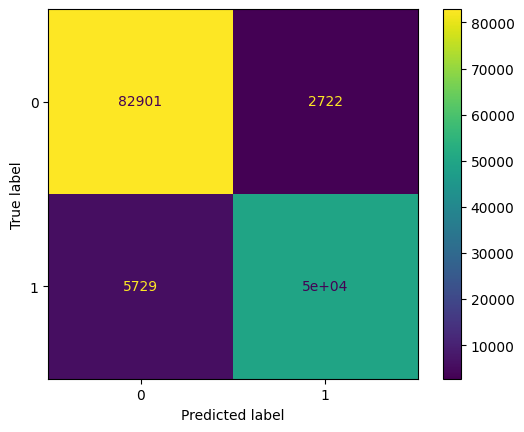

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     85623
           1       0.95      0.90      0.92     55314

    accuracy                           0.94    140937
   macro avg       0.94      0.93      0.94    140937
weighted avg       0.94      0.94      0.94    140937



In [6]:
# Split data into train and test sets
X = data.drop(['url', 'type', 'malicious', 'category', 'domain'], axis=1)
y = data['malicious']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
confusion_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()
print("Classification Report:")
print(classification_report(y_test, y_pred))

##### XGBoost

In [7]:
# # Split data into train and test sets
# X = data.drop(['url', 'type', 'malicious', 'category', 'domain'], axis=1)
# y = data['malicious']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize and train the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)
# xgb_classifier.fit(X_train, y_train)

# # Predict on the test set
# y_pred = xgb_classifier.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
# print("Confusion Matrix:")
# confusion_matrix = confusion_matrix(y_test, y_pred)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
# cm_display.plot()
# plt.show()
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

##### LightGBM

In [8]:
# # Split data into train and test sets
# X = data.drop(['url', 'type', 'malicious', 'category', 'domain'], axis=1)
# y = data['malicious']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define LightGBM dataset
# train_data = lgb.Dataset(X_train, label=y_train)
# test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# # Set LightGBM parameters
# params = {
#     'objective': 'binary',
#     'metric': 'binary_error',
#     'verbosity': -1
# }

# # Train the model
# bst = lgb.train(params, train_data, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])

# # Predict on the test set
# y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
# y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred_binary)
# print("Accuracy:", accuracy)
# print("Confusion Matrix:")
# confusion_matrix = confusion_matrix(y_test, y_pred_binary)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
# cm_display.plot()
# plt.show()
# print("Classification Report:")
# print(classification_report(y_test, y_pred_binary))

##### Support Vector Machine (SVM)

In [9]:
# # Split data into train and test sets
# X = data.drop(['url', 'type', 'malicious', 'category', 'domain'], axis=1)
# y = data['malicious']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize and train the SVM classifier
# svm_classifier = SVC(kernel='linear', C=0.000000000000000001, random_state=42)
# svm_classifier.fit(X_train, y_train)

# # Predict on the test set
# y_pred = svm_classifier.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
# print("Confusion Matrix:")
# confusion_matrix = confusion_matrix(y_test, y_pred)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
# cm_display.plot()
# plt.show()
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

##### Logistic Regression

In [10]:
# # Split data into train and test sets
# X = data.drop(['url', 'type', 'malicious', 'category', 'domain'], axis=1)
# y = data['malicious']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize and train the Logistic Regression classifier
# logreg_classifier = LogisticRegression(random_state=42)
# logreg_classifier.fit(X_train, y_train)

# # Predict on the test set
# y_pred = logreg_classifier.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
# print("Confusion Matrix:")
# confusion_matrix = confusion_matrix(y_test, y_pred)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
# cm_display.plot()
# plt.show()
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

##### Convolutional Neural Network (CNN)

In [11]:
# # Split data into train and test sets
# X = data.drop(['url', 'type', 'malicious', 'category', 'domain'], axis=1)
# y = data['malicious']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define CNN model
# model = Sequential([
#     Embedding(input_dim=X.shape[0], output_dim=16, input_length=X.shape[1]),
#     Conv1D(128, 5, activation='relu'),
#     GlobalMaxPooling1D(),
#     Dense(64, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print("Test Accuracy:", accuracy)

# # Predict on test data
# y_pred = model.predict(X_test)
# y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
# print("Confusion Matrix:")
# confusion_matrix = confusion_matrix(y_test, y_pred)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
# cm_display.plot()
# plt.show()
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

##### Recurrent Neural Network (RNN)

In [12]:
# # Split data into train and test sets
# X = data.drop(['url', 'type', 'malicious', 'category', 'domain'], axis=1)
# y = data['malicious']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define RNN model
# model = Sequential([
#     Embedding(input_dim=X.shape[0], output_dim=16, input_length=X.shape[1]),
#     LSTM(64),
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2)

# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print("Test Accuracy:", accuracy)

# # Predict on test data
# y_pred = model.predict(X_test)
# y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)
# print("Confusion Matrix:")
# confusion_matrix = confusion_matrix(y_test, y_pred)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
# cm_display.plot()
# plt.show()
# print("Classification Report:")
# print(classification_report(y_test, y_pred))